In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
sns.set_context('talk')
sns.set_style('whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Kernel regression

In the post I'm going to introduce *Kernel* regression as a precurser to Gaussian Processes regression. To start with we'll review linear regression and then introduce a very simple extension using a limited number kernels, which we'll think of as just like multivariate regression. A more complete picture will arise when we let the number of kernels being used equal the number of data.  Finally we'll abandon ordinary least squares regression and show kernel regression proper as a way of averaging data.  




## Linear regression uses the multivariate normal distribution

Our data are $N$ observations of a reponse and independent variable: $(y_i, X_i)\ i = 1, ..., N$. The $X_i$ could be vectors (for multivariate linear regression) of could be realisations of a single variable.  Initially we'll keep things simple and assume the latter.  

The main model assumptions are that each $y_i$ is normally distributed, with a mean given by a linear function of the dependent variable, $\mu_i = \beta_0 + \beta_1x_i$ and a common variance, $\sigma^2$.  In other words: 

$$
\begin{align}
y_i \sim & \mathcal{N}(\mu, \sigma^2)\\
\sim & \mathcal{N}(\beta_0 + \beta_1X_i, \sigma^2)
\end{align}
$$

When we want to denote all the $N$ observations at once, we can write simply $y$ and $X$, which then denote $N\times1$ vectors.  In the case of $p$ independent variables, $X$ would be a $N\times p$ *matrix*.  Using this notation we can write our model using the multivariate normal distribution (MVN): 

$$
y \sim  \mathcal{N}(\beta_0 + \beta_1X, \sigma^2 I)
$$

Where $I$ is the $N\times N$ identity matrix. This gives us our most instructive form (for our case) of the linear regression model:  
* The mean of the MVN is a vector whose elements linearly increase or decrease (assuming we've ordered the values in $X$).
* The covariance matrix is just the identity multiplied by a common variance.  
* The covariance matrix doesn't have any off-diagonal non-zero elements and so the errors and therefore the values of $y_i$ are not correlated with each other. 
* The MVN is $N$-dimensional.  The dimenions of the MVN are the different data points. 

Our task is to estimate the $\beta$'s by minimizing the squared errors (alternatively maximimizing the log-likelihood) between the estimated mean values $\hat{\beta}_0 + \hat{\beta}_1 X_i$ the true values $y_i$ (the hats denote an estimated quantity). 

An example is shown below in graphical format. We're using the OLS model from the python module [`statsmodels`](https://www.statsmodels.org/stable/index.html).  Here the true values of the parameters are $\beta_0 = 2$ and $\beta_1 = 0.5$.  

In [2]:
x = np.linspace(-1,1,20)
y = 2 + 0.5*x + np.random.normal(0, 0.1, len(x))
df = pd.DataFrame({'x': x, 'y': y})
result = smf.ols('y ~ x', data=df).fit()

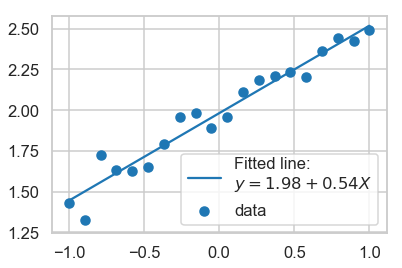

In [3]:
plt.scatter(x, y, label='data')
plt.plot(x, result.fittedvalues, 
         label='Fitted line:\n$y = {0:4.2f} + {1:4.2f}X$'.format(*result.params))
_ = plt.legend()

The model we've fitted is a MVN model with a mean vector of: 

In [4]:
result.fittedvalues

0     1.445661
1     1.502089
2     1.558516
3     1.614944
4     1.671371
5     1.727799
6     1.784226
7     1.840654
8     1.897081
9     1.953509
10    2.009936
11    2.066364
12    2.122791
13    2.179219
14    2.235646
15    2.292074
16    2.348502
17    2.404929
18    2.461357
19    2.517784
dtype: float64

The estimated variance, $\hat{\sigma}^2 = s^2$ is the sum of squares of the residuals divided by the degrees of freedom: 

$$
s^2 = \frac{\sum (y_i-\hat{y_i})^2}{N-2}
$$

These are the diagonal elements of the covariance matrix, which in this case is: 


In [5]:
result.mse_resid

0.006394484997558226

## If the data are non-linear we can add polynomial terms

If the data are non-linear in $X$ then we could add a $X^2$ term to the regression.  i.e. 
$$
Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon
$$

This is known as [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). 

An example of this is shown below, where we've just added a $\beta_2 = -1$ term to the previous equation. 

In [6]:
x = np.linspace(-1,1,20)
y = 2 + 0.5*x - x**2 + np.random.normal(0, 0.1, len(x))
df = pd.DataFrame({'x': x, 'y': y})
result = smf.ols('y ~ x + np.power(x, 2)', data=df).fit()

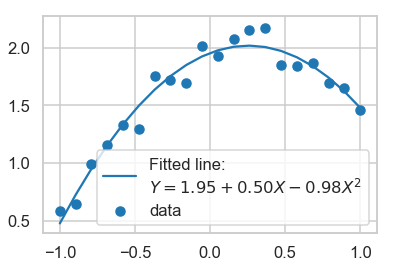

In [7]:
plt.scatter(x, y, label='data')
plt.plot(x, result.fittedvalues, 
         label='Fitted line:\n$Y = {0:4.2f} {1:+4.2f}X {2:+4.2f}X^2$'.format(*result.params))
_ = plt.legend()

The model is still a multivariate normal but the elements of the mean function are now no longer linearly increasing. Like the linear case the covariance matrix still has no off-diagonal non-zero elements. 

We could extend this to any number of cubic, quartic etc. terms.  In other words, we would be using a polynomial basis to fit the non-linear relationship between X and Y. The problem with this is that the value of $y$ at $X= -1$ is dependent on the value of $Y$ at $X = 1$.  i.e. a polynomial basis is *non-local*.  

To avoid the problem of non-locality we can use a series of *kernels* instead of a the polynomial terms.  


## Kernels also allow non-linearities
A [kernel][1] is a symmetric function that takes two inputs and returns a single, positive output. A kernel measures the similarity between the two inputs.
A popular kernel is the *Gaussian* kernel, which is shown below: 

$$
K(x, x') = \exp\left(-\frac{||x - x'||^2}{w}\right)
$$

$w$ is known as the bandwidth.  This measures the similarity between two points $x$ and $x'$.  
[1]: https://en.wikipedia.org/wiki/Kernel_(statistics)#Nonparametric_statistics


In Kernal regression we replace the powers of $X$ in polynomial regression with the values of the kernel at different values of $X$. These values are known as **knots** or **centroids** which we'll label $q$ to highlight the fact they are logically distinct from the covarite $X$. The equation below has three centroids ($q_1,q_2,q_3$): 

$$
y_i = \gamma_1 K(X_i, q_1) + \gamma_2 K(X_i, q_2) + \gamma_3 K(X_i, q_3) + \epsilon
$$

To estimate the parameters, $\gamma$, we can (kind of) still use all the machinery of OLS regression. To demonstrate let's use some highly non-linear data, a noisey sine curve:  

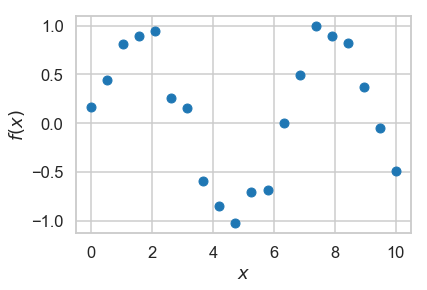

In [8]:
np.random.seed(1)
N = 20
x = np.linspace(0, 10, N)
ytrue = np.sin
y = ytrue(x) + np.random.normal(0,0.1, size=N)
with sns.plotting_context('talk', font_scale=1):
    plt.plot(x, y, 'o')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')

 Let's have 5 knots equally spaced across the $X$ axis each with a bandwidth of 2:

In [137]:
def gauss_kernel(x, knots, w=2):
    # Gaussian kernel using predetermined knots. 
    unnormed = [np.exp(-(x-knot)**2/w) for knot in knots]
    normed = unnormed #[x/x.sum() for x in unnormed]
    return np.array(normed).T

In [143]:
n_knots = 5
knots = np.linspace(np.floor(x.min()), np.ceil(x.max()), n_knots)
w = 2
K = gauss_kernel(x, knots, w=w) 

The variable `K` is a matrix of dimension $N \times 5$.  You can think of it as a design matrix like multivariate linear regression where each column is a different variable.  

For each knot, there is a kernel defined over all the data. i.e. for each knot, there's a value of $K$ for each value of $X$.  Let's plot this: 

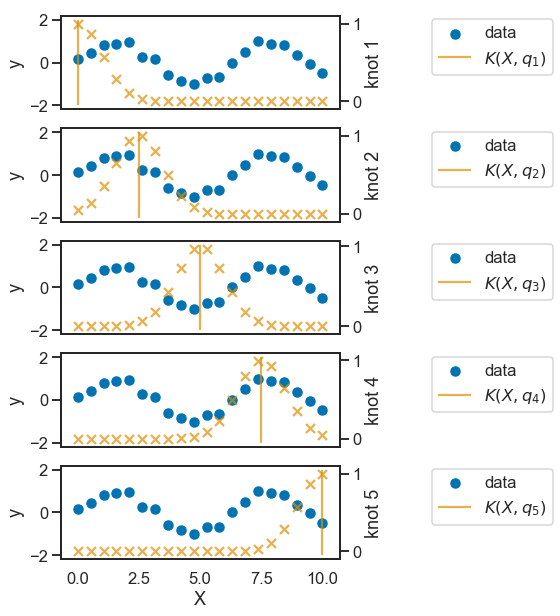

In [145]:
with sns.plotting_context('talk'):
    sns.set_style('white')
    fig, axes = plt.subplots(n_knots, figsize=(5,10), 
                             sharex=True, sharey=True)
    cols = sns.color_palette('colorblind')
    
    for i, ax in enumerate(axes):
        
        ax.scatter(x, y, color=cols[0], marker='o', label='data')
        ax2 = ax.twinx()
        
        ax2.scatter(x, K.T[i], color=cols[1], alpha=0.7, marker='x')
        ax.vlines(knots[i], -2, 2, color=cols[1], alpha=0.7, 
                  label=r'$K(X, q_{%s} )$' %  str(i+1))
        ax.legend(bbox_to_anchor=(1.3, 1.05))
        ax2.set_ylabel('knot %s' % str(i+1))
        ax.set_ylabel('y')
    ax.set_xlabel('X')


## Kernel regression is local
As you can see, the  x's look like Gaussian's (because they are) around the knot center (the vertical line).  The value of $K$ is non-zero only for a small number of data points around the knot center. 

So why do this?  

Well, it allows us to assign a regression coefficient to a small subset of the data points - those that are similar or *local* to the knots.  For example, those data far the first knot, i.e.  $ |x - q_1|^2 \gg w$ the value of  $K \simeq 0$.  This means, the only terms in the regression equation are those near $q_1$.  i.e.: 

$$
\hat{Y} \approx \gamma_1 K(X, q_1) = \gamma_1 \exp\left(-\frac{||X-q_1||^2}{w}\right)
$$

(From now on I'll drop write $K(X, q_1)$ as $K_1(X)$ to save space on the figures.)

The predicted value of the  response variable approaches $\gamma_1$ as the values of the input variables approach the first knot, $q_1$ from either side. 

For values of $X$ that fall inbetween $q_1$ and $q_2$, the predicted value of the response variable will  be a weighted average of predominately $\gamma_1$ and $\gamma_2$.  The weights will be the values of $K_1(X)$ and $K_2(X)$. 

*So Kernel regression makes predictions at $X$ based on the average of those regression coefficients, $\gamma$, in the neighbourhood of $X$. *

## Conditioning a kernel regression model

To find the coefficients let's just use the OLS model and treat each $K_i$ as a different independent variables. This means we conditioning the model just like multivariate linear regression. So $K$ is a $N\times 5$ matrix, where the $K_{ij}$ element is the value $K_{j}(X_i)$. 

In [146]:
model = sm.OLS(y, K)
result = model.fit()

Let's plot the data and the prediction.  To make the prediction curve nice and smooth, we've created a new vector of X values, very tightly spaced. 

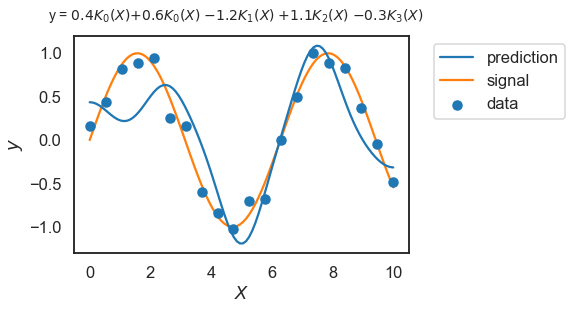

In [153]:
Xnew = np.linspace(x.min(), x.max(), 100)
Knew = gauss_kernel(Xnew, knots, w=1)
y_predict = result.predict(Knew)

linelabel = ' '.join([r'$ %+4.1f K_{%s}(X)$' % (x,i) for i, x in enumerate(result.params[1:])])
linelabel = 'y = '+' '.join([r'$ %4.1f K_{%s}(X)$' % (x,i) for i, x in enumerate(result.params[:1])]) + linelabel

plt.scatter(x, y, label='data')
plt.plot(Xnew, y_predict, label='prediction')
plt.plot(Xnew, ytrue(Xnew), label='signal', zorder=0)
plt.xlabel("$X$"); plt.ylabel("$y$")
plt.legend(bbox_to_anchor=(1.05, 1))
_ = plt.suptitle(linelabel, fontsize=14)


## Kernel regression is improved with data centered knots

The fit isn't great - it *kind of* gets the shape but misses the amplitude badly. How could we improve the fit? 

Well, in our model we have arbitrarily set three parameters: 
1. The number of knots
2. The location of the knots
3. The bandwidth

One approach to improve our fit would be to use cross validation to select these parameters, but that seems difficult with the location of the knots. 

A much better approach (for points 1 and 2) is to use *the data as the knot points*.  

The regression equation will be then: 

$$
y(X) = \sum \gamma_i K(X, q_i = X_i) + \epsilon
$$

Observe that there are now as many parameters as data points.  This fact is what makes this a [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) regression method. 


Let's run the regression in the same way as before (we'll keep the bandwidth the same). We'll call this new $K$ matrix `Kx` to highlight the fact that the knots are centered at values of $X$. 

In [158]:
Kx = gauss_kernel(x, knots=x, w=1)
Kx.shape

(20, 20)

So now `Kx` is an $N\times N$ instead of $N\times 5$ matrix.  

In [159]:
model = sm.OLS(y, Kx)
result = model.fit()

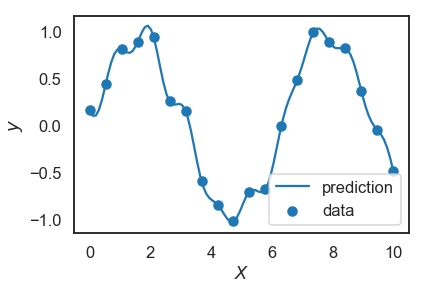

In [165]:
Xnew = np.linspace(x.min(), x.max(), 100)
Knew = gauss_kernel(Xnew, x, w=1) 
y_predict = result.predict(Knew)

plt.scatter(x, y, label='data')
plt.plot(Xnew, y_predict, label='prediction')
plt.xlabel("$X$"); plt.ylabel("$y$")
_ = plt.legend()


Let's disect this. 

**The good**: the regression line goes through the data!  But that's only to be expected - we have as many parameters ($\gamma$'s) as data points, so that's hardly suprising. 

**The bad**  we've failed spectacularly to get the shape correct.  We've totally [overfit](https://en.wikipedia.org/wiki/Overfitting) our model. 

## The bandwidth controls the smoothness
Let's see what happens when we change the bandwith by an arbitrary factor of 20 each way.  

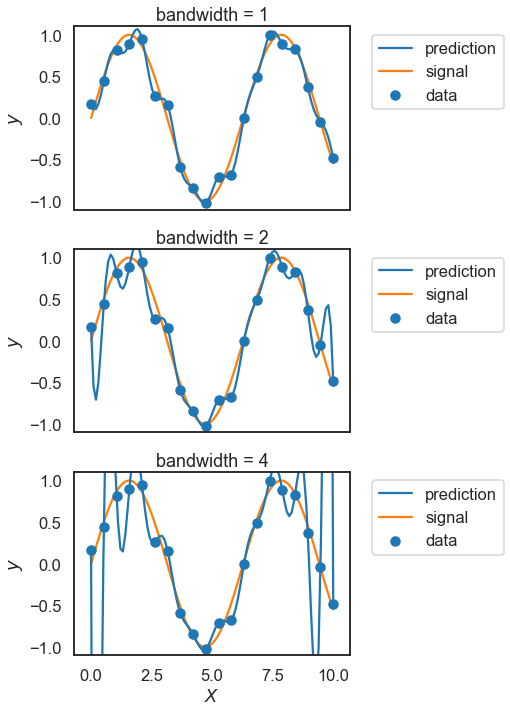

In [230]:
bandwidths = [1, 2, 4]
fig, axes  = plt.subplots(len(bandwidths), figsize=(5,10), sharex=True)

for i, bw in enumerate(bandwidths): 
    ax = axes[i]
    # Fit model
    Kx = gauss_kernel(x, knots=x, w=bw)
    model = sm.OLS(y, Kx)
    result = model.fit()
    #predict over all x
    Xnew = np.linspace(x.min(), x.max(), 100)
    Knew = gauss_kernel(Xnew, x, w=bw) 
    y_predict = result.predict(Knew)

    # plot
    ax.scatter(x, y, label='data')
    ax.plot(Xnew, y_predict, label='prediction')
    ax.plot(Xnew, ytrue(Xnew), label='signal', zorder=0)
    ax.set_ylabel("$y$")
    ax.set_title('bandwidth = {}'.format(bw))
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_ylim(-1.1,1.1)
ax.set_xlabel("$X$");    
plt.tight_layout()

So as the bandwidth increases we get a smoother curver which results in a better fit, in the sense that it reproduces the actual signal (the sine curve) rather than the noise. 

Why is this?  First, let's remember that the value of the predicted response, $\hat{y}$ at any particular point is the weighted average of the estimated $\gamma$ parameters. The weights are given by the value of the kernel at that point. 

As you can see below, as the bandwidth increases the range of $X$ over which the kernel is non-zero increases.  

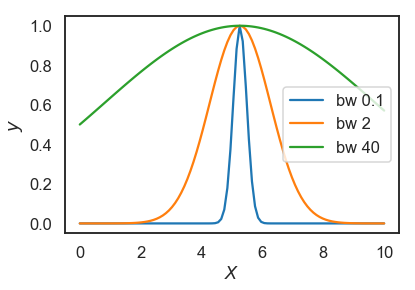

In [167]:
for bw in bandwidths: 
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[10], label='bw {}'.format(bw))
plt.xlabel("$X$"); plt.ylabel("$y$")
_ = plt.legend()

So let's plot ALL the kernels and zoom in on the region around $X = \pi/2$ (the first top of the curve) for the low bandwidth first. 

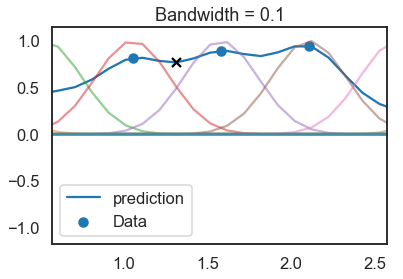

In [168]:
Xnew = np.linspace(x.min(), x.max(), 100)

bw = bandwidths[0]
Kx = gauss_kernel(x, knots=x, w=bw)

# Fit
model = sm.OLS(y, Kx)
result = model.fit()
# predict
Knew = gauss_kernel(Xnew, x, w=bw) 
y_predict = result.predict(Knew)

#plot
plt.plot(Xnew, y_predict, label='prediction')
for i in range(len(x)):
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[i], alpha=0.5)
plt.scatter(x, y, label='Data')
plt.scatter(Xnew[13], y_predict[13], marker='x', color='k', zorder=2+len(x))
plt.xlim(np.pi/2-1, np.pi/2+1)
plt.title('Bandwidth = {}'.format(bw))
_ = plt.legend()


Take the point marked with a black 'x'.  The kernels significantly greater than zero at that point are from the neighbouring two data points.  Essentially the predicted value is an interpolation of just the two neighbouring $\gamma$ parameters.

Now let's look at the high bandwidth case. 



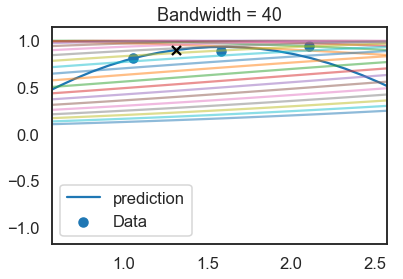

In [169]:
Xnew = np.linspace(x.min(), x.max(), 100)

bw = bandwidths[-1]
Kx = gauss_kernel(x, knots=x, w=bw)

# Fit
model = sm.OLS(y, Kx)
result = model.fit()
# predict
Knew = gauss_kernel(Xnew, x, w=bw) 
y_predict = result.predict(Knew)

#plot
plt.scatter(Xnew[13], y_predict[13], marker='x', color='k', zorder=2+len(x))
plt.plot(Xnew, y_predict, label='prediction')
for i in range(len(x)):
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[i], alpha=0.5)
plt.scatter(x, y, label='Data')
plt.xlim(np.pi/2-1, np.pi/2+1)
plt.title('Bandwidth = {}'.format(bw))
_ = plt.legend()


Here we can clearly see that many more of the kernel values are non-zero at the point marked 'x'.  This means the prediction takes into account many more $\gamma$'s, albeit those further away from 'x' are weighted less. The change in $\hat{y}$ as we traverse the $X$ axis will therefor be slower. 

So clearly the bandwidth has an essential role to play in Kernel regression. How should be select it? A single parameter like this is really ammenable to selection through cross-validation although as we will see there are other ways. 

## The best parameters are the response variable

But what about the values of the $\gamma$'s? If you know the assumptions required for multivariate linear regression to work well you might have noticed a problem.  *The $K_i$'s are heavily correlated with each other*. In other words our regression suffers from *massive [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)*. Let's look a the two of the kernels:  



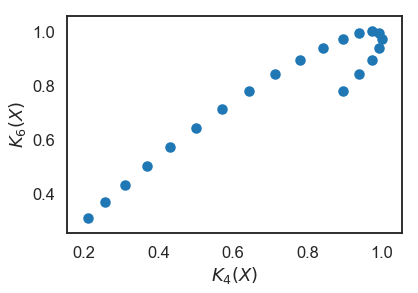

In [170]:
i, j = 4, 6
plt.scatter(Kx[:,i], Kx[:,j])
plt.xlabel(r'$K_{% d}(X)$' % i); _ = plt.ylabel(r'$K_{% d}(X)$' % j)

This will result in *almost* meaningless parameter estimates with huge confiendence intervals. Crucially though, all the large numbers cancel and we get a decent prediction out.  This is reflected in the fact that the [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) for each cooeficient fails (each coefficient is not different from zero), where as the [F-test](https://en.wikipedia.org/wiki/F-test) succeeds (all coefficients are different from zero). 

In [171]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     33.04
Date:                Mon, 27 Aug 2018   Prob (F-statistic):           1.78e-05
Time:                        11:41:00   Log-Likelihood:                 19.022
No. Observations:                  20   AIC:                            -14.04
Df Residuals:                       8   BIC:                            -2.096
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.898e+10   1.83e+11      0.432      0.677   -3.43e+11    5.01e+11
x2         -4.992e+11   1.15e+12     -0.433      0.677   -3.16e+12    2.16e+12
x3          1.193e+12   2.75e+12      0.434      0.676   -5.14e+12    7.53e+12
x4         -1.084e+12   2.49e+12     -0.436      0.674   -6.82e+12    4.65e+12
x5         -3.249e+11   7.58e+11     -0.429      0.679   -2.07e+12    1.42e+12
x6          1.014e+12   2.32e+12      0.436      0.674   -4.34e+12    6.37e+12
x7          2.847e+11   6.65e+11      0.428      0.680   -1.25e+12    1.82e+12
x8         -9.001e+11   2.06e+12     -0.437      0.673   -5.65e+12    3.85e+12
x9         -4.923e+11   1.14e+12     -0.432      0.677   -3.12e+12    2.13e+12
x10         7.336e+11   1.67e+12      0.439      0.672   -3.12e+12    4.59e+12
x11         7.324e+11   1.68e+12      0.435      0.675   -3.15e+12    4.61e+12
x12        -5.066e+11   1.15e+12     -0.441      0.671   -3.16e+12    2.14e+12
x13         -9.01e+11   2.06e+12     -0.437      0.674   -5.66e+12    3.85e+12
x14          3.04e+11   6.85e+11      0.444      0.669   -1.28e+12    1.88e+12
x15         1.011e+12   2.31e+12      0.438      0.673   -4.32e+12    6.34e+12
x16        -3.384e+11   7.64e+11     -0.443      0.670    -2.1e+12    1.42e+12
x17        -1.082e+12   2.47e+12     -0.438      0.673   -6.78e+12    4.61e+12
x18         1.203e+12   2.74e+12      0.439      0.672   -5.11e+12    7.51e+12
x19         -5.06e+11   1.15e+12     -0.440      0.671   -3.16e+12    2.15e+12
x20         8.038e+10   1.82e+11      0.441      0.671    -3.4e+11    5.01e+11
==============================================================================
Omnibus:                        0.508   Durbin-Watson:                   3.639
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.009
Skew:                           0.029   Prob(JB):                        0.995
Kurtosis:                       3.088   Cond. No.                     1.09e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So clearly we have a problem.  Let's try to figure out what the $\gamma$s *should* be and see if we can fix it.  

We've already said the value of $K_i(X)$ gives the weight of $\gamma_i$ in the sum predicting $y$:

$$
\hat{y}(X) = \sum \gamma_i K(X, q_i = X_i)
$$

If the weights all summed to one at any particular $X$ then it would make sense to have $\gamma_i = y_i$.  Well, we can do this simply dividing each $K_i(X)$ by the sum of all kernels at $X$:
$$
\hat{y}(X_i) = \sum_j y_j \frac{K(X_i, q_j = X_j)}{\sum_k K(X_i, q_k = X_k)}
$$

Or in matrix notation: 

$$
\hat{y}(X) = W \times y
$$

where

$$
W_{ij} = \frac{K(X_i, q_j = X_j)}{\sum_k K(X_i, q_k = X_l)}
$$


Now we can abandon OLS regression all together and just use this analytic expression to make predictions. 

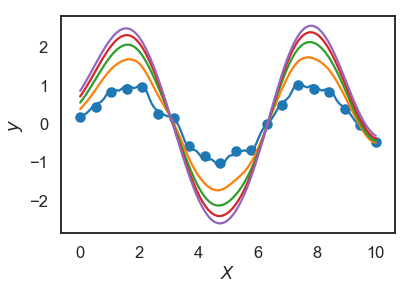

In [226]:
bw = 0.12
for bw in np.linspace(0.1,1, 5):
    Xnew = np.linspace(x.min(), x.max(), 100)
    Kx = gauss_kernel(Xnew, knots=x, w=bw)


    y_best = np.dot(Kx, y)


    plt.plot(Xnew, y_best, label='prediction')
#     plt.plot(Xnew, ytrue(Xnew), label='signal', zorder=0)
    plt.xlabel("$X$"); plt.ylabel("$y$")
#     plt.legend(bbox_to_anchor=(1.05, 1))

plt.scatter(x, y, label='data')

In [189]:
Xnew = np.linspace(x.min(), x.max(), n)
Kx = gauss_kernel(Xnew, knots=x, w=bw)
Norm = gauss_kernel(x,x, w=bw).sum(axis=1)
print(Kx.shape)
print(Norm.shape)

(200, 20)
(20,)


In [192]:
from statsmodels.nonparametric.kernel_regression import KernelReg



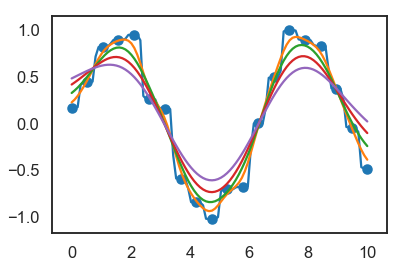

In [225]:
for bw in np.linspace(0.1,1, 5):
    nw_mod = KernelReg(endog=[y], exog=[x], reg_type='lc', bw=[np.ones(len(x))*bw], var_type='c')
    nw_result = nw_mod.fit()
    Xnew = np.linspace(x.min(), x.max(), 100)
#     plt.plot(x, nw_result[0], label='prediction')
    plt.plot(Xnew, nw_mod.fit(Xnew)[0])
plt.scatter(x, y, label='data')